In [ ]:
!pip install transformers==2.6.0;
#Wasn't working- error about not building tokenizer wheel 
#ERROR: Could not build wheels for tokenizers which use PEP 517 and cannot be installed directly
#Just installed transformers - v2.9.1 (latest)

In [1]:
import torch
from tqdm import tqdm, trange
from nltk import sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertConfig
import transformers
from transformers import BertForTokenClassification
import nltk
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')
import re

[nltk_data] Downloading package punkt to /Users/Lucy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Bert Classifier

In [2]:
def get_sentences(text):
    sentences = []
    for sentence in sent_tokenize(text):
        for split_sentence in re.split('\n+',sentence):
            if split_sentence == '':
                continue
            sentences.append(split_sentence)
    return sentences
    
    
def tokenize_text(text):
    text_tokens = []
    for sentence in get_sentences(text):
        text_tokens.append(extra_tokenization(nltk.word_tokenize(sentence)))
    return text_tokens

def extra_tokenization(tokens):
    updated_tokens = []
    regex1 = re.compile("[a-zA-Z]{3,}/[a-zA-Z]{3,}")
    regex2 = re.compile("^[-]{1}[a-zA-Z]{3,}")
    regex3 = re.compile("^[.]{1}[a-zA-Z]{3,}")
    regex4 = re.compile("^[/]{1}[a-zA-Z]{3,}")
    regex5 = re.compile("^[']{1}[a-zA-Z]{3,}")
    regex6 = re.compile("^[a-zA-Z]{4,}[.]{1}[a-zA-Z]{4,}")
    regex7 = re.compile("^[a-zA-Z]{3,}[-]{1}$")
    regex8 = re.compile('^([A-Za-z][a-z]+)([A-Za-z][a-z]+){0,3}([A-Z][a-z]+)+$')
    regex9 = re.compile('[A-Za-z]+[/]$')
    for token in tokens:
        candidate1 = regex1.findall(token)
        candidate2 = regex2.findall(token)
        candidate3 = regex3.findall(token)
        candidate4 = regex4.findall(token)
        candidate5 = regex5.findall(token)
        candidate6 = regex6.findall(token)
        candidate7 = regex7.findall(token)
        candidate8 = regex8.findall(token)
        candidate9 = regex9.findall(token)
        if candidate1:
            new_tokens = candidate1[0].split('/')
            new_tokens.insert(1,'/')
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate2:
            new_tokens = candidate2[0].split('-')
            new_tokens[0] = '-'
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate3:
            new_tokens = candidate3[0].split('.')
            new_tokens[0] = '.'
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate4:
            new_tokens = candidate4[0].split('/')
            new_tokens[0] = '/'
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate5:
            new_tokens = candidate5[0].split('\'')
            new_tokens[0] = '\''
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate6:
            new_tokens = candidate6[0].split('.')
            new_tokens.insert(1,'.')
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate7:
            new_tokens = candidate7[0].split('-')
            new_tokens[1] = '-'
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate8:
            new_tokens = candidate8[0]
            for item in new_tokens:
                if item:
                    updated_tokens.append(item)
        elif candidate9:
            new_tokens = candidate9[0].split('/')
            new_tokens[1] = '/'
            for item in new_tokens:
                updated_tokens.append(item)
        elif special_case(token):
            for item in special_case(token):
                updated_tokens.append(token)
        else:
            updated_tokens.append(token)
    return updated_tokens

def special_case(word):
    if word == 'abnormalitiesincludes':
        return ['abnormalities','includes']
    return []

In [3]:
def bert_tokenizer_text(txt):
    sentences = get_sentences(txt)
    tagged_sentences = []
    for sentence in sentences:
        if re.search('[a-zA-Z1-9]', sentence):
            tagged_sentences.append(bert_tokenizer_sent(sentence))
    return tagged_sentences

def bert_tokenizer_sent(sentence):
    tokenized_sentence = tokenizer.convert_tokens_to_ids(bert_tokenizer_helper(sentence)) 
    input_ids = torch.tensor([tokenized_sentence])
    # computing NER tags
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    # join bpe split tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    return_list = []
    for token, label in zip(new_tokens,new_labels):
        return_list.append([token,label])
    return bert_chunker(return_list)


def bert_tokenizer_helper(sentence):
    tokens = extra_tokenization(word_tokenize(sentence))
    tokenized_sentence = []
    for word in tokens:
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)
    return tokenized_sentence

# Update to B - I tag chunks, whenever adverse reaction tag happens in text
# just take consecutive AdverseReaction tokens, regardless of B or I tag
def bert_chunker(sentence):
    chunked_list = []
    group_chunk = ['','']
    for word in sentence:
        if word[1] == 'O':
            if group_chunk != ['','']:
                final_token =  [group_chunk[0][:-1],group_chunk[1]] #wrap up chunking
                chunked_list.append(final_token)
                group_chunk = ['','']
            chunked_list.append(word) #just O-tag
        else: #different tags from O
            if group_chunk != ['',''] and group_chunk[1] != word[1][2:]: #if currently chunking, and different NER tag follows
                final_token =  [group_chunk[0][:-1],group_chunk[1]]
                chunked_list.append(final_token)
                group_chunk = [word[0] + ' ',word[1][2:]]
            else:
                group_chunk[0] +=  word[0] + ' ' #more of same classifier
                group_chunk[1] = word[1][2:]
    if group_chunk != ['','']:
        final_token =  [group_chunk[0][:-1],group_chunk[1]]
        chunked_list.append(final_token)
    return chunked_list

In [4]:
tag_values = ['B-AdverseReaction','I-AdverseReaction','B-Severity','I-Severity','B-Factor','I-Factor','B-DrugClass','I-DrugClass','B-Negation','I-Negation','O','B-Animal','I-Animal']
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
!pip install scispacy

In [140]:
# normalize the data (takes a lot of Collab RAM)
from scispacy.candidate_generation import CandidateGenerator
from scispacy.umls_utils import UmlsKnowledgeBase

candidate_generator = CandidateGenerator()

kb = UmlsKnowledgeBase() # 2017 UMLS database

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/tfidf_vectors_sparse.npz not found in cache, downloading to /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmptkz767nv
Finished download, copying /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmptkz767nv to cache at /Users/Lucy/.scispacy/datasets/ea855fd121a193f03190a91417c209d4cd97e63d3ce4b456c248ef7c13a4ca77.03518aabd12de2103a27a50302f37c3d87b0f313a8be08b5ec306c9c4334b9b1.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/nmslib_index.bin not found in cache, downloading to /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmphizk_1uo
Finished download, copying /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmphizk_1uo to cache at /Users/Lucy/.scispacy/datasets/5f620d1bd549a98c005ed601a73806ea2cd1a86ae6c54bbc62bcb3b452ca2630.27a7ac6807fde6628311ff7d70b86fefc640d0eb70637b544c591722a2c16c2a.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkin

/Users/Lucy/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/Lucy/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/concept_aliases.json not found in cache, downloading to /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmpy7gquq9t
Finished download, copying /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmpy7gquq9t to cache at /Users/Lucy/.scispacy/datasets/0f064d20aefab965d5772b2100f8436b3541e7d5313c76cfe5fe070902f149fe.31df9cdb04729860a81bd6c980224ed2bff582586c398d0c9b96ae4e257b9da2.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_2017_aa_cat0129.json not found in cache, downloading to /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmpnv0hqxku
Finished download, copying /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmpnv0hqxku to cache at /Users/Lucy/.scispacy/datasets/13b30cd31cd37c1b52f3df6ea023061172d16e9941660e677fdbb29489af7410.4ad71d86ce780e00cab131c7e3b81acfd2f11dd80ccd61125c8bcde506f2ab8a.umls_2017_aa_cat0129.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_seman

In [5]:
def normalise_text(tagged_text):
    text = tagged_text
    for sent in text:
        for word in sent:
            if word[1] == 'AdverseReaction':
                aliases = get_aliases(word[0],.7)
                if aliases == None:
                    continue
                word[0] = aliases[0]
    return text

def link_severity(tagged_text):
    text = tagged_text
    relations = []
    for sentence in text:
        adv_reactions = []
        sev = []
        for index,word in enumerate(sentence):
            if word[1] == 'AdverseReaction':
                adv_reactions.append((word[0],index))
            if word[1] == 'Severity':
                sev.append((word[0],index))
        for s in sev:
            min = 1000
            link = ''
            for adv in adv_reactions:
                if np.abs(adv[1]-s[1]<min):
                    min = adv[1]-s[1]
                    link = [s[0],adv[0]]
            if link:
                relations.append(link)
    return relations

def get_adverse_reactions(tagged_text):
    adv_reactions = []
    for sent in tagged_text:
        for word in sent:
            if word[1] == 'AdverseReaction':
                adv_reactions.append(word[0])
    return adv_reactions

In [ ]:
#Install en_core_sci_lg #(SLOW in jupyter - done)
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [10]:
#Copied from normal copy_text_mining
import en_core_sci_lg # (colab: takes too much RAM)
import scispacy
from scispacy.umls_linking import UmlsEntityLinker
from scispacy.abbreviation import AbbreviationDetector
from scispacy.candidate_generation import CandidateGenerator
from scispacy.umls_utils import UmlsKnowledgeBase

In [ ]:
candidate_generator = CandidateGenerator() #takes RAM

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/tfidf_vectors_sparse.npz not found in cache, downloading to /var/folders/8g/9mrmp56x079fcmm856gyvkhr0000gn/T/tmpzbc56875


In [ ]:
kb = UmlsKnowledgeBase() # 2017 UMLS database #takes RAM

In [8]:
def get_aliases(entity,neigbhours):
    concept_id = candidate_generator.__call__([entity],k=neigbhours)[0][0].concept_id
    print(kb.cui_to_entity[concept_id].definition)
    return list(set([x.lower() for x in kb.cui_to_entity[concept_id].aliases]))

Load pretrained BERT classifier

In [6]:
#Bert
bert_out_address = '/Users/Lucy/Documents/Information retrieval & Text mining/Jupyter folder/Bert21052020' #'/content/drive/My Drive/Text mining project (04 2020)/Bert21052020'

model = BertForTokenClassification.from_pretrained(bert_out_address,num_labels=len(tag2idx))
tokenizer = BertTokenizer.from_pretrained(bert_out_address, do_lower_case=False)
model.eval();

# How to BERT

In [7]:
text = "Skin rash is bad. Headache is also not very good. Severe stomache pain is the worst."
tagged_text = bert_tokenizer_text(text) #feed string from drug label of choice
print(tagged_text)

[[['Skin rash', 'AdverseReaction'], ['is', 'O'], ['bad', 'O'], ['.', 'O']], [['Headache', 'AdverseReaction'], ['is', 'O'], ['also', 'O'], ['not', 'O'], ['very', 'O'], ['good', 'O'], ['.', 'O']], [['Severe', 'Severity'], ['stomache pain', 'AdverseReaction'], ['is', 'O'], ['the', 'O'], ['worst', 'O'], ['.', 'O']]]


In [8]:
normalise_text(tagged_text) #importing packages heavy for this

NameError: name 'get_aliases' is not defined

In [9]:
link_severity(tagged_text)

[['Severe', 'stomache pain']]

In [10]:
get_adverse_reactions(tagged_text)

['Skin rash', 'Headache', 'stomache pain']

If wish to compare with paper they used, anesthesia, antihistamine, antipsychotic, aspirin, atenolol, atorvastatin, dexamethasone, diazepam, dopamine, ephedrine, gabapentin, galantamine, heparin, ibuprogen, ...
Side effects: gi bleeding, dizziness, insomnia, bleeding, vision loss, hoarseness, anxiety, nosebleeds, ...

In [11]:
print(tagged_text)

[[['Skin rash', 'AdverseReaction'], ['is', 'O'], ['bad', 'O'], ['.', 'O']], [['Headache', 'AdverseReaction'], ['is', 'O'], ['also', 'O'], ['not', 'O'], ['very', 'O'], ['good', 'O'], ['.', 'O']], [['Severe', 'Severity'], ['stomache pain', 'AdverseReaction'], ['is', 'O'], ['the', 'O'], ['worst', 'O'], ['.', 'O']]]


In [12]:
def special_case(word):
    if word == 'abnormalitiesincludes':
        return ['abnormalities','includes']
    return []

def extra_tokenization(tokens):
    updated_tokens = []
    regex1 = re.compile("[a-zA-Z]{3,}/[a-zA-Z]{3,}")
    regex2 = re.compile("^[-]{1}[a-zA-Z]{3,}")
    regex3 = re.compile("^[.]{1}[a-zA-Z]{3,}")
    regex4 = re.compile("^[/]{1}[a-zA-Z]{3,}")
    regex5 = re.compile("^[']{1}[a-zA-Z]{3,}")
    regex6 = re.compile("^[a-zA-Z]{4,}[.]{1}[a-zA-Z]{4,}")
    regex7 = re.compile("^[a-zA-Z]{3,}[-]{1}$")
    regex8 = re.compile('^([A-Za-z][a-z]+)([A-Za-z][a-z]+){0,3}([A-Z][a-z]+)+$')
    regex9 = re.compile('[A-Za-z]+[/]$')
    for token in tokens:
        candidate1 = regex1.findall(token)
        candidate2 = regex2.findall(token)
        candidate3 = regex3.findall(token)
        candidate4 = regex4.findall(token)
        candidate5 = regex5.findall(token)
        candidate6 = regex6.findall(token)
        candidate7 = regex7.findall(token)
        candidate8 = regex8.findall(token)
        candidate9 = regex9.findall(token)
        if candidate1:
            new_tokens = candidate1[0].split('/')
            new_tokens.insert(1,'/')
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate2:
            new_tokens = candidate2[0].split('-')
            new_tokens[0] = '-'
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate3:
            new_tokens = candidate3[0].split('.')
            new_tokens[0] = '.'
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate4:
            new_tokens = candidate4[0].split('/')
            new_tokens[0] = '/'
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate5:
            new_tokens = candidate5[0].split('\'')
            new_tokens[0] = '\''
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate6:
            new_tokens = candidate6[0].split('.')
            new_tokens.insert(1,'.')
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate7:
            new_tokens = candidate7[0].split('-')
            new_tokens[1] = '-'
            for item in new_tokens:
                updated_tokens.append(item)
        elif candidate8:
            new_tokens = candidate8[0]
            for item in new_tokens:
                if item:
                    updated_tokens.append(item)
        elif candidate9:
            new_tokens = candidate9[0].split('/')
            new_tokens[1] = '/'
            for item in new_tokens:
                updated_tokens.append(item)
        elif special_case(token):
            for item in special_case(token):
                updated_tokens.append(token)
        else:
            updated_tokens.append(token)
    return updated_tokens

def get_sentences(text):
    sentences = []
    for sentence in sent_tokenize(text):
        for split_sentence in re.split('\n+',sentence):
            if split_sentence == '':
                continue
            sentences.append(split_sentence)
    return sentences
    

def span(text):  
  sentence_id = 0
  offset = 0
  for sentence in get_sentences(text):
    tokens = extra_tokenization(nltk.word_tokenize(sentence))
    pos_tags = nltk.pos_tag(tokens)
    for token,pos_tag in zip(tokens,pos_tags):
        offset = text.find(token,offset)
        yield [token, offset, offset + len(token),sentence_id,pos_tag[1]]
        offset += len(token)
    sentence_id += 1
    

def get_section_name(mention_name):
    for section in root.findall('./Text/Section'):
        if section.get('id') == mention_name:
            return section.get('name')
        
        
def reduceTokens(tokens):
  for token in tokens:
    try:
      token.pop(1)
      token.pop(1)
    except:
      break

In [13]:
from nltk import sent_tokenize, word_tokenize
from tqdm import tqdm
import os 
import re
counter_total = 0
counter = 0;

# importing all packages we need
import nltk
import numpy as np
import re
#import wget # downloads files
import tarfile # unzip tar files
import xml.etree.ElementTree as ET # used to xml files
import os # to access your directories 
import pandas as pd # useful table stuff to do manipulations on (and stuff)
import matplotlib.pyplot as plt # plotting stuff when necessary 
import zipfile # to unzip zips
from tqdm import tqdm # To show progress bar for for-loops
import spacy

path = '/Users/Lucy/Documents/Information retrieval & Text mining/Jupyter folder'
directory_unannotated = path + '/unannotated_xml'

# create pandas framework for the training set
df_cols_unannotated = ["file_name","adverse_reactions","warnings_and_precautions","boxed_warnings"]
df_rows_unannotated = []
for filename in tqdm(sorted(os.listdir(directory_unannotated))):
    if filename.endswith(".xml"):
        fullname = os.path.join(directory_unannotated, filename)
        tree = ET.parse(fullname)
        root = tree.getroot()
        text_adverse_reactions, text_warnings_and_precautions, text_boxed_warnings = "","",""
        for section in root.findall('./Text/Section'):
            if section.get('name') == "adverse reactions":
                text_adverse_reactions = section.text
            if section.get('name') == "warnings and precautions":
                text_warnings_and_precautions = section.text
            if section.get('name') == "boxed warnings":
                text_boxed_warnings = section.text  
        df_rows_unannotated.append({"file_name": filename,"adverse_reactions": text_adverse_reactions, "warnings_and_precautions": text_warnings_and_precautions, "boxed_warnings": text_boxed_warnings})
df = pd.DataFrame(df_rows_unannotated,columns = df_cols_unannotated)

100%|██████████| 2209/2209 [00:10<00:00, 206.92it/s]


In [ ]:
#extra tokenization slow (heats up) - ISSUE
span_text = lambda x : span(x)
df['adverse_reactions'] = df['adverse_reactions'].apply(span_text).apply(list) # each xml gets tokenized
df['warnings_and_precautions'] = df['warnings_and_precautions'].apply(span_text).apply(list) # each xml gets tokenized
df['boxed_warnings'] = df['boxed_warnings'].apply(span_text).apply(list) # each xml gets tokenized

In [ ]:
#Really heated up computer - ISSUE
filename in tqdm(df['file_name']):
      index = df[df['file_name']==filename].index.values.astype(int)[0]
      fullname = os.path.join(directory_unannotated, filename)
      tree = ET.parse(fullname)
      root = tree.getroot()
      tokens_adverse_reactions = df['adverse_reactions'][index]
      for token in tokens_adverse_reactions:
          token.append("O")
      tokens_warnings_and_precautions = df['warnings_and_precautions'][index]
      for token in tokens_warnings_and_precautions:
          token.append("O")
      tokens_boxed_warnings = df['boxed_warnings'][index]
      for token in tokens_boxed_warnings:
          token.append("O")
      

df['adverse_reactions'].apply(reduceTokens)
df['warnings_and_precautions'].apply(reduceTokens)
df['boxed_warnings'].apply(reduceTokens)
df = df.set_index('file_name',drop = True)
df.to_pickle('./unannotated.pkl')
print(counter,counter_total)

In [14]:
unannotated_df = pd.read_pickle(path + '/unannotated.pkl')
print(unannotated_df) #empty

In [16]:
print(df)

         file_name                                  adverse_reactions  \
0         8MOP.xml      VII. ADVERSE REACTIONS\n\n  A. METHOXSALEN...   
1      ABELCET.xml      ADVERSE REACTIONS\n\n  The total safety da...   
2     ABILIFY0.xml      6 ADVERSE REACTIONS\n\n  EXCERPT:   Common...   
3     ABILIFY1.xml      6 ADVERSE REACTIONS\n\n  EXCERPT:   Common...   
4     ABILIFY2.xml      6 ADVERSE REACTIONS\n\n  The following adv...   
...            ...                                                ...   
2203  ZYPREXA0.xml      6 ADVERSE REACTIONS\n\n  When using ZYPREX...   
2204  ZYPREXA1.xml      6 ADVERSE REACTIONS\n\n  When using ZYPREX...   
2205    ZYTIGA.xml      6 ADVERSE REACTIONS\n\n  The following are...   
2206    ZYVOX0.xml      6 ADVERSE REACTIONS\n\n  EXCERPT:   Most c...   
2207    ZYVOX1.xml      6 ADVERSE REACTIONS\n\n  EXCERPT:   Most c...   

                               warnings_and_precautions  \
0                                                         
1    

In [151]:
df[df['boxed_warnings'].str.contains('boxed warning', case=False)]                                                     

,file_name,adverse_reactions,warnings_and_precautions,boxed_warnings
0,8MOP.xml,VII. ADVERSE REACTIONS\n\n A. METHOXSALEN...,,\n\n BOXED WARNING: \n\n Methoxsalen with ...
2,ABILIFY0.xml,6 ADVERSE REACTIONS\n\n EXCERPT: Common...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCER...,\n\n BOXED WARNING: WARNING: INCREASED MORT...
3,ABILIFY1.xml,6 ADVERSE REACTIONS\n\n EXCERPT: Common...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCER...,\n\n BOXED WARNING: WARNINGS: INCREASED MOR...
4,ABILIFY2.xml,6 ADVERSE REACTIONS\n\n The following adv...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCER...,\n\n BOXED WARNING: WARNING: INCREASED MORT...
6,ABRAXANE.xml,6 ADVERSE REACTIONS\n\n Because clinical ...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCER...,\n\n BOXED WARNING: WARNING: NEUTROPENIA\n...
...,...,...,...,...
2193,ZURAMPIC.xml,6 ADVERSE REACTIONS\n\n The following adv...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCER...,\n\n BOXED WARNING: \n\n \n\n WARNI...
2194,ZYBAN.xml,6 ADVERSE REACTIONS\n\n The following adv...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCER...,\n\n BOXED WARNING: WARNING: NEUROPSYCHIATR...
2196,ZYDELIG.xml,6 ADVERSE REACTIONS\n\n The following ser...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCER...,\n\n BOXED WARNING: WARNING: FATAL AND SERI...
2203,ZYPREXA0.xml,6 ADVERSE REACTIONS\n\n When using ZYPREX...,5 WARNINGS AND PRECAUTIONS\n\n\n\n When u...,\n\n BOXED WARNING: WARNING: INCREASED MORT...


In [167]:
df[df['file_name'].str.contains('zetia', case=False)]

,file_name,adverse_reactions,warnings_and_precautions,boxed_warnings
2155,ZETIA.xml,6 ADVERSE REACTIONS\n\n The following ser...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCER...,


In [162]:
def find_adv_reactions(drug, section):
    df1 = df[df['file_name'].str.contains(drug, case=False)] #Find by drug name in table df
    if df1.empty:
        print(drug + " not found")
        return []
    else:
        text_drug = df1.iat[0,section] #sometimes no boxed warnings or warnings & precautions
        tagged_drug = bert_tokenizer_text(text_drug)
        drug_adv_reactions = get_adverse_reactions(tagged_drug)
        drug_adv_reactions = [x.lower() for x in drug_adv_reactions]
        return drug_adv_reactions

In [37]:
#Finding adverse reactions with Bert and storing to list
aspirin_adv_reactions1 = find_adv_reactions('aspirin',1)
aspirin_adv_reactions2 = find_adv_reactions('aspirin',2)
diazepam_adv_reactions1 = find_adv_reactions('diazepam',1)

In [45]:
def drug_row(top_adv_reactions,drug_adv_reactions):
    new_list=list(top_adv_reactions)
    for i in range(len(new_list)):
        if new_list[i] in drug_adv_reactions:
            new_list[i] = 1
        else:
            new_list[i] = 0
    return new_list

In [114]:
#Choose which adverse reactions to compare to

#top_adv_reactions = ['pain','nausea','diarrhea','rash','infections','headache','hypersensitivity','fatigue','vomiting','bleeding','death']
top_adv_reactions = ['pain','nausea','vomiting','bleeding']

#Finding drug rows
aspirin_row = drug_row(top_adv_reactions,aspirin_adv_reactions2)
diazepam_row = drug_row(top_adv_reactions,diazepam_adv_reactions1)
print(aspirin_row)
print(diazepam_row)

[0, 1, 1, 1]
[1, 0, 1, 0]


In [115]:
#Combining drug rows
drug_rows_part = np.array([aspirin_row, diazepam_row])
print(drug_rows_part)
print(top_adv_reactions)

[[0 1 1 1]
 [1 0 1 0]]
['pain', 'nausea', 'vomiting', 'bleeding']


In [48]:
def make_chord_matrix(drug_rows_part):
    adv_reactions_rows_part = drug_rows_part.transpose()

    num_drugs = np.shape(drug_rows_part)[0] #number of drugs considered
    drug_zeroes = np.zeros((num_drugs,num_drugs), dtype=int)
    num_AR = np.shape(adv_reactions_rows_part)[0] #number of adverse reactions
    adv_react_zeroes = np.zeros((num_AR,num_AR), dtype=int)

    drug_rows_full = np.column_stack((drug_zeroes,drug_rows_part))
    adv_reactions_rows_full = np.column_stack((adv_reactions_rows_part,adv_react_zeroes))

    matrix_AR_array = np.row_stack((drug_rows_full,adv_reactions_rows_full))
    matrix_AR = matrix_AR_array.tolist()
    
    return matrix_AR

In [116]:
#make chord matrix
matrix_AR = make_chord_matrix(drug_rows_part)
print(matrix_AR)

[[0, 0, 0, 1, 1, 1], [0, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]]


In [118]:
from chord import Chord

drug_names = ["ASPIRIN", "DIAZEPAM"]
names = drug_names + top_adv_reactions
print(names)

Chord(matrix_AR, names, opacity=0.7, padding=0.1, width=1200, label_color=["#0000ff","#0000ff","#ff0000","#ff0000","#ff0000","#ff0000"], wrap_labels=False).show() 
#cut off labels ? can't print - when move orientation then cuts off names


['ASPIRIN', 'DIAZEPAM', 'pain', 'nausea', 'vomiting', 'bleeding']


##Therapeutic indications of drugs - RxClass API

In [53]:
#Install package once - RxClass API python wrapper by Ian Phorsman
!pip install rxclass

In [54]:
#Set up

# To access API helpers:
from rxclass_api import RxClassHelpers

# To access API wrapper functions directly:
from rxclass_api import RxAPIWrapper

# To start using available helper functions create a helper instance.
helper = RxClassHelpers()

helper = RxClassHelpers(filename='data')
with helper:
    ...

In [126]:
drugs_treat_tuple = helper.drugs_that_may('treat', 'bipolar')
drugs_treat_list = drugs_treat_tuple[1]
print(drugs_treat_list)

i


In [ ]:
#Finding adverse reactions with Bert and storing to list
drug1_adv_reactions1 = find_adv_reactions('cyclophosphamide',1)
drug2_adv_reactions1 = find_adv_reactions('ibrutinib',1)
drug3_adv_reactions1 = find_adv_reactions('rituximab',1)

In [177]:
top_adv_reactions = ['pain','nausea','diarrhea','rash','infections','headache','hypersensitivity','fatigue','vomiting','bleeding','dizziness']
#top_adv_reactions = ['pain','nausea','vomiting','bleeding']

drugs_treat_list = ['lantus','januvia','victoza','levemir','humalog']

new_list=list(drugs_treat_list)
for i in range(len(drugs_treat_list)):
    new_list[i] = find_adv_reactions(drugs_treat_list[i], 1)
    if len(new_list[i]) != 0:
        new_list[i] = drug_row(top_adv_reactions, new_list[i])
    else:
        continue   

In [178]:
new_list2 = [x for x in new_list if x != []]
print(new_list2)

[[0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]]


In [190]:
ibu = find_adv_reactions('ibuprofen', 2)
print("\n".join(ibu))


inhibit platelet aggregation
prolong bleeding time
inhibit platelet aggregation
prolong bleeding time
displace bilirubin


In [192]:
asp = find_adv_reactions('aspirin', 1)
asp2 = list(dict.fromkeys(asp))
print("\n".join(asp2))

hypersensitivity
allergy
bleeding
headache
dyspepsia
abdominal pain
nausea
diarrhea
stroke
fatal
death
convulsions
vomiting
hemorrhage rectum
melena
hemorrhoids
gi hemorrhage
pain
fatigue
back pain
accidental injury
malaise
asthenia
syncope
amnesia
confusion
anorexia
somnolence
arthralgia
arthritis
arthrosis
myalgia
coughing
upper respiratory tract infection
cardiac failure
hemorrhage nos
epistaxis
purpura
neoplasm nos
anemia
dizziness
transient ischemic attack
angina pectoris
allergic reaction
fever
hypotension
coma
paresthesia
cerebral hemorrhage
intracranial hemorrhage
subarachnoid hemorrhage
gastritis
ulceration
tinnitus
deafness
tachycardia
palpitation
arrhythmia
supraventricular tachycardia
cholelithiasis
jaundice
hepatic function abnormal
hyperglycemia
thirst
hematoma
gingival bleeding
agitation
uterine hemorrhage
hyperpnea
asthma
bronchospasm
hemoptysis
pulmonary edema
taste loss
pruritus
urticaria
renal insufficiency
hematuria
flushing
hypothermia
chest pain
cerebral edema
hyp

In [183]:
df[df['file_name'].str.contains('aspirin', case=False)]

,file_name,adverse_reactions,warnings_and_precautions,boxed_warnings
162,ASPIRIN.xml,6 ADVERSE REACTIONS\n\n The following ad...,5 WARNINGS AND PRECAUTIONS\n\n\n\n EXCE...,


In [108]:
import random
random.seed(2020)

file_name = df['file_name']
new_file_name = [x[:-4] for x in file_name]
random_list = random.sample(new_file_name, 5)
print(random_list)

['EXFORGE1', 'THIOLA', 'SUPRANE', 'TRIBENZOR', 'PRED1']


In [109]:
#not that fast
#find adverse reaction fit for random list
new_list=list(random_list)
for i in range(len(random_list)):
    new_list[i] = find_adv_reactions(random_list[i], 1)
    if len(new_list[i]) != 0:
        new_list[i] = drug_row(top_adv_reactions, new_list[i])
    else:
        continue   
print(new_list)

[[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0], [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [110]:
new_list2 = [x for x in new_list if x != []]
print(new_list2)

[[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0], [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [127]:
df[df['file_name'].str.contains('pred1', case=False)] #sometimes no adverse reactions

,file_name,adverse_reactions,warnings_and_precautions,boxed_warnings
1509,PRED1.xml,ADVERSE REACTIONS\n\n Adverse reactions i...,,


In [181]:
#make chord matrix
new_list2 = np.array(new_list2)
matrix_AR = make_chord_matrix(new_list2)
print(matrix_AR)

#Chord diagram
from chord import Chord

drug_names = [x.upper() for x in drugs_treat_list]
#drug_names = ['EXFORGE1', 'THIOLA', 'SUPRANE', 'TRIBENZOR', 'PRED1', 'SKLICE', 'EMTRIVA0', 'CICLOPIROX0', 'ISONIAZID']
names = drug_names + top_adv_reactions
print(names)

Chord(matrix_AR, names).show() 

[[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
['LANTUS', 'JANUVIA', 'VICTOZA', 'LEVEMIR', 'HUMALOG', 'pain', 'nausea', 'diarrhea', 'rash', 'infections', 'headache', 'hypersensitivity', 'fatigue', 'vomiting', 'bleeding', 'dizziness']


##Attempt with Plotly - in other document

###Trying to draw on human figure adverse events

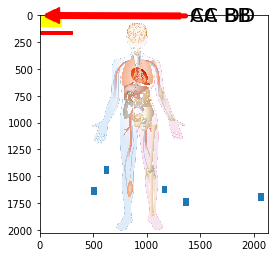

In [139]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# Get an example image
import matplotlib.cbook as cbook
image_file = cbook.get_sample_data('/Users/Lucy/Documents/Information retrieval & Text mining/Jupyter folder/human_body.jpg')
img = plt.imread(image_file)

# Make some example data
x = np.random.rand(5)*img.shape[1]
y = np.random.rand(5)*img.shape[0]

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(img)

# Now, loop through coord arrays, and create a circle at each x,y pair
for xx,yy in zip(x,y):
    circ = Circle((xx,yy),50)
    rect = Rectangle((xx,yy),50,70)
    ax.add_patch(rect)
    

rect1 = matplotlib.patches.Rectangle((-200,-100), 400, 200, color='yellow')
rect2 = matplotlib.patches.Rectangle((0,150), 300, 20, color='red')
rect3 = matplotlib.patches.Rectangle((-300,-50), 40, 200, color='#0099FF')
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

    
ax.annotate('AA BB', fontsize=20, xy=(.25, .75),
            xycoords='data', xytext=(150, -6),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 5.,
                            color = 'red')
            )
ax.annotate('CC DD', fontsize=20, xy=(.25, .25),
            xycoords='data', xytext=(150, -6),
            textcoords='offset points',
            arrowprops=dict(width = 5.,
                            headwidth = 15.,
                            frac = 0.2,
                            shrink = 0.05,
                            linewidth = 2,
                            color = 'red')
            )
#axis('off') - removes axis

# Show the image
plt.show()

/Users/Lucy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
/Users/Lucy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
/Users/Lucy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
  fig.canvas.print_figure(bytes_io, **kw)


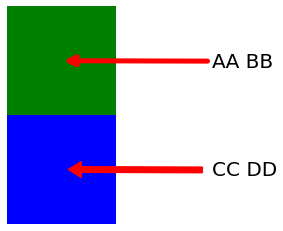

In [131]:
from pylab import *
from matplotlib import colors
# A = [[1,2,3,4,5]]
A = [[0],[1]]
Amap = colors.ListedColormap(['blue','green'])

fig = figure(1)
ax = fig.add_subplot(111, autoscale_on=False)
imshow(A, cmap=Amap, interpolation='nearest')
ax.annotate('AA BB', fontsize=20, xy=(.25, .75),
            xycoords='data', xytext=(150, -6),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 5.,
                            color = 'red')
            )
ax.annotate('CC DD', fontsize=20, xy=(.25, .25),
            xycoords='data', xytext=(150, -6),
            textcoords='offset points',
            arrowprops=dict(width = 5.,
                            headwidth = 15.,
                            frac = 0.2,
                            shrink = 0.05,
                            linewidth = 2,
                            color = 'red')
            )
axis('off')
savefig('graph-py.pdf')
show()
close()